# Objetivos e Índice

#### Objetivos

Neste notebook a ideia principal é explorar/modelar as bases de trabalho

#### Índice

0. Imports: há a importação das libs e bases

1. Análise descritiva: buscando algumas informações descritivas das bases

2. Modelagem: alguns experimentos para estudo do comportamento da base e modelagem que atenda o objetivo do projeto

3. Salvando o modelo final: exportando a pipeline do modelo

# 0. Imports

#### 1. Importando as libs

In [ ]:
# Importanto Libs e ferramentas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import matplotlib as mpl
from scipy.stats import ranksums

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#### 2. Importando as bases

In [7]:
# Importando a base de conexões
csv_con_path = "../aux/conexoes_espec.csv"
df_con = pd.read_csv(csv_con_path, sep=';')

# Head
display(df_con.head())

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN


In [8]:
# Importando a base de indivíduos
csv_ind_path = "../aux/individuos_espec.csv"
df_ind = pd.read_csv(csv_ind_path, sep=';')

# Head
display(df_ind.head())

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668


# 1. Análise Descritiva

Tópico para estudo dos dados da base e exploração visual inicial

## 1.1 Indivíduos

Primeiramente, estudando a base de indivíduos

In [4]:
# Contagem de linhas

len(df_ind)

1000000

In [5]:
# Verificando os tipos de dados

df_ind.dtypes

name                           int64
idade                        float64
estado_civil                  object
qt_filhos                    float64
estuda                       float64
trabalha                     float64
pratica_esportes             float64
transporte_mais_utilizado     object
IMC                          float64
dtype: object

In [6]:
# Verificando valores nulos

display(df_ind.isnull().sum())

name                              0
idade                         95937
estado_civil                  50073
qt_filhos                     28867
estuda                        40130
trabalha                       6353
pratica_esportes             149124
transporte_mais_utilizado     43033
IMC                          113870
dtype: int64

In [7]:
# Análise descritiva das variáveis numéricas

display(df_ind.describe())

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
count,1000000.000000,904063.000000,971133.000000,959870.000000,993647.000000,850876.000000,886130.000000
mean,500000.500000,30.008431,0.928406,0.442588,0.556739,0.599823,22.472079
std,288675.278932,10.951566,0.997289,0.496693,0.496771,0.489934,7.073692
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.852828
25%,250000.750000,22.000000,0.000000,0.000000,0.000000,0.000000,17.420851
50%,500000.500000,29.000000,1.000000,0.000000,1.000000,1.000000,21.431200
75%,750000.250000,37.000000,1.000000,1.000000,1.000000,1.000000,26.378197
max,1000000.000000,124.000000,9.000000,1.000000,1.000000,1.000000,89.158204


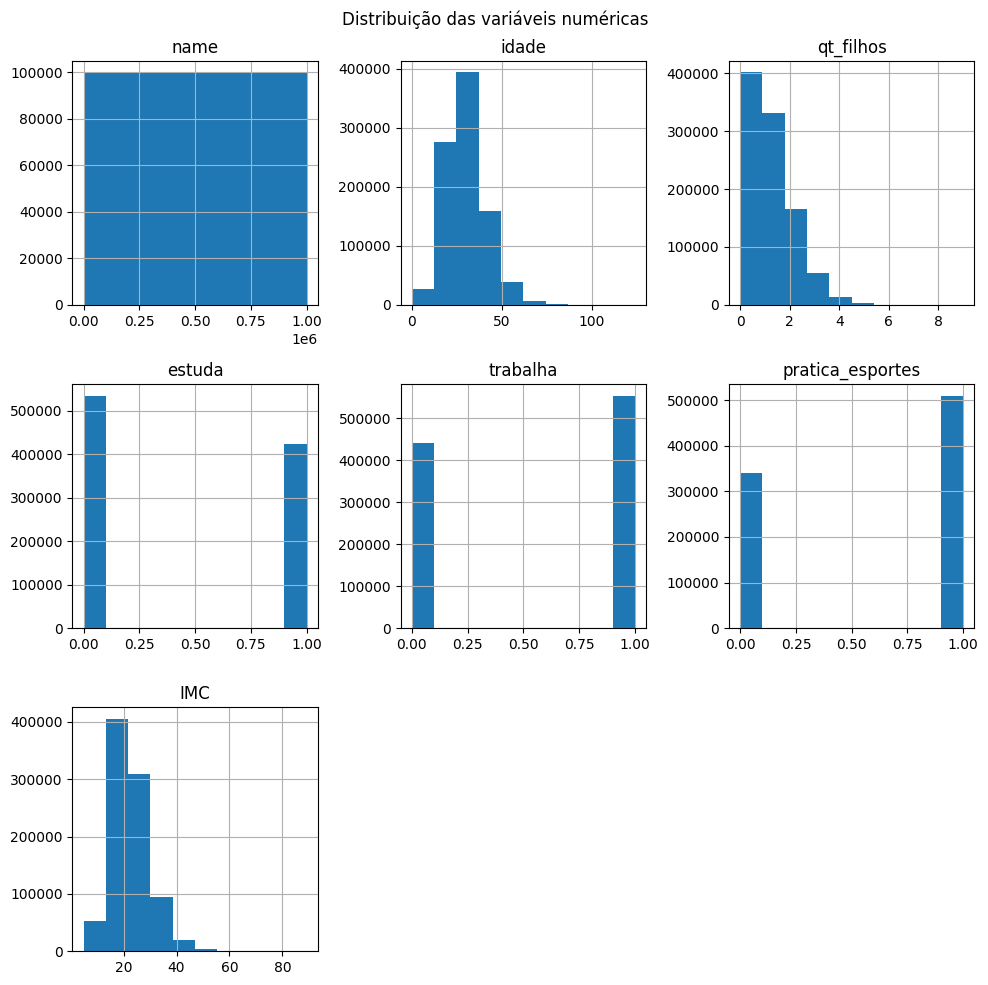

In [8]:
# Explorando as distribuições

df_ind.hist(figsize=(10, 10))
plt.suptitle('Distribuição das variáveis numéricas')
plt.tight_layout()
plt.show()

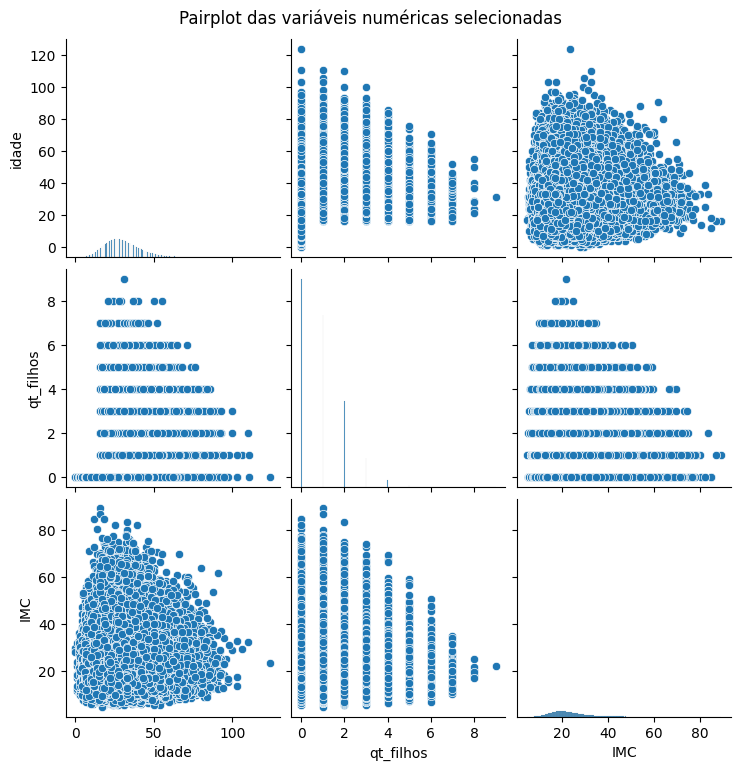

In [9]:
sns.pairplot(df_ind[['idade', 'qt_filhos', 'IMC']])
plt.suptitle('Pairplot das variáveis numéricas selecionadas', y=1.02)
plt.show()

In [10]:
# Variáveis categóricas

display(df_ind.describe(include='object'))

,estado_civil,transporte_mais_utilizado
count,949927,956967
unique,4,3
top,solteiro,publico
freq,420637,574779


## 1.2 Conexões

Estudando agora a base de conexões

In [11]:
# Contagem de linhas

len(df_con)

999999

In [12]:
# Verificando os tipos de dados

df_con.dtypes

V1               int64
V2               int64
grau            object
proximidade     object
prob_V1_V2     float64
dtype: object

In [13]:
# Verificando valores nulos

display(df_con.isnull().sum())

V1                  0
V2                  0
grau                0
proximidade         0
prob_V1_V2     500000
dtype: int64

In [14]:
# Análise descritiva das variáveis numéricas

display(df_con['prob_V1_V2'].describe())

count    499999.000000
mean          0.485162
std           0.173963
min           0.074462
25%           0.351677
50%           0.486413
75%           0.618210
max           0.942245
Name: prob_V1_V2, dtype: float64

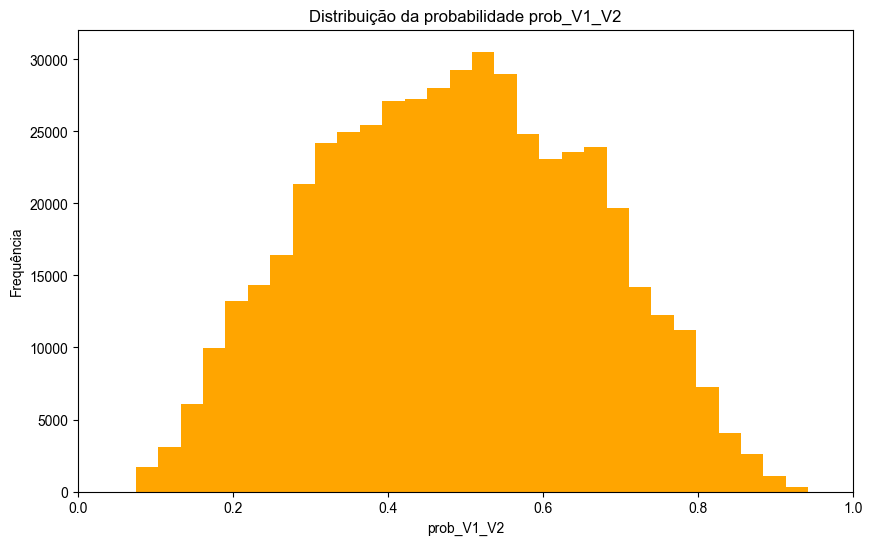

In [38]:
# Define a fonte Arial como padrão
mpl.rcParams['font.family'] = 'Arial'

# Plotando o histograma das probabilidades
df_con['prob_V1_V2'].plot(
    kind='hist',
    figsize=(10, 6),
    bins=30,
    color='orange',
    title='Distribuição da probabilidade prob_V1_V2'
)
plt.xlabel('prob_V1_V2')
plt.ylabel('Frequência')
plt.xlim(0, 1)
plt.show()

In [16]:
# Variáveis categóricas

display(df_con.describe(include='object'))

,grau,proximidade
count,999999,999999
unique,3,4
top,trabalho,visita_rara
freq,333548,400238


## 1.3 Base enriquecida

Cruzando os dados de indivíduos e conexões, podemos explorar mais da distribuição da taxa de contaminação pelas características das pessoas.

In [53]:
# Renomeando colunas para o merge
df_ind_v1 = df_ind.rename(columns=lambda x: f"{x}_V1" if x != 'name' else 'V1')
df_ind_v2 = df_ind.rename(columns=lambda x: f"{x}_V2" if x != 'name' else 'V2')

# Merge dos dados com as conexões
df_merged = df_con.merge(df_ind_v1, on='V1', how='left')
df_merged = df_merged.merge(df_ind_v2, on='V2', how='left')

# Remover registros sem target (probabilidade de contagio)
df_model = df_merged[df_merged['prob_V1_V2'].notna()].copy()

display(df_model.head())

,V1,V2,grau,proximidade,prob_V1_V2,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,...,transporte_mais_utilizado_V1,IMC_V1,idade_V2,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2
0,1,2,trabalho,visita_frequente,0.589462,44.0,divorciado,1.0,1.0,0.0,...,publico,22.200956,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
1,1,3,trabalho,visita_rara,0.708465,44.0,divorciado,1.0,1.0,0.0,...,publico,22.200956,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,2,5,trabalho,visita_rara,0.638842,24.0,casado,0.0,0.0,0.0,...,publico,25.378720,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
5,3,7,familia,visita_casual,0.709608,35.0,solteiro,1.0,0.0,0.0,...,particular,19.952393,55.0,solteiro,1.0,1.0,1.0,1.0,particular,NaN
7,4,9,amigos,visita_casual,0.465209,50.0,casado,1.0,1.0,1.0,...,publico,26.732053,42.0,divorciado,1.0,0.0,1.0,NaN,publico,40.793339


#### Algumas análises visuais

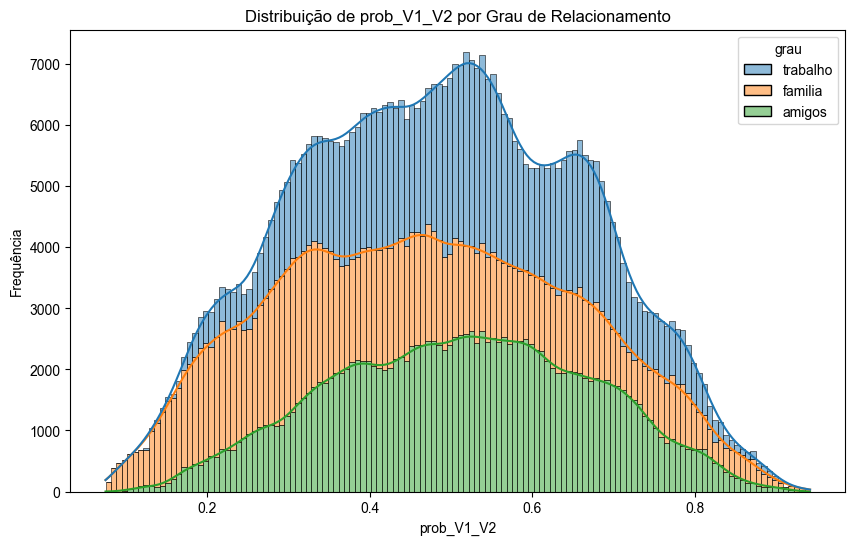

In [72]:
# Taxa de contágio por grau de relacionamento

plt.figure(figsize=(10, 6))
sns.histplot(data=df_model, x='prob_V1_V2', hue='grau', kde=True, multiple='stack')
plt.title('Distribuição de prob_V1_V2 por Grau de Relacionamento')
plt.xlabel('prob_V1_V2')
plt.ylabel('Frequência')
plt.show()

Grau familiar tente a ter taxas inferiores se comparada a amigos e colegas de trabalho.

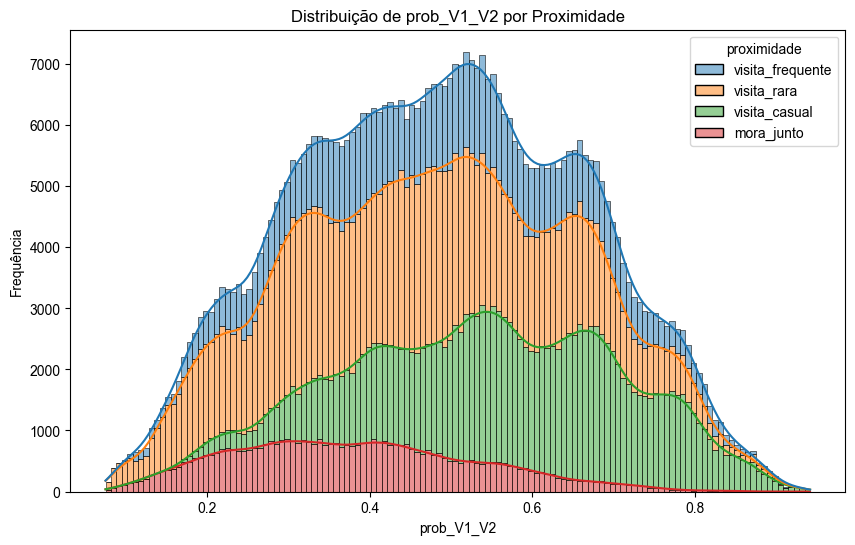

In [73]:
# Taxa de contágio por proximidade (frequência de contato)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_model, x='prob_V1_V2', hue='proximidade', kde=True, multiple='stack')
plt.title('Distribuição de prob_V1_V2 por Proximidade')
plt.xlabel('prob_V1_V2')
plt.ylabel('Frequência')
plt.show()

Visitas casuais tendem a ter taxas mais elevadas se comparada a visitas raras e frequentes, sendo que pessoas que moram junto tendem a ter taxas inferiores as outras classificações.

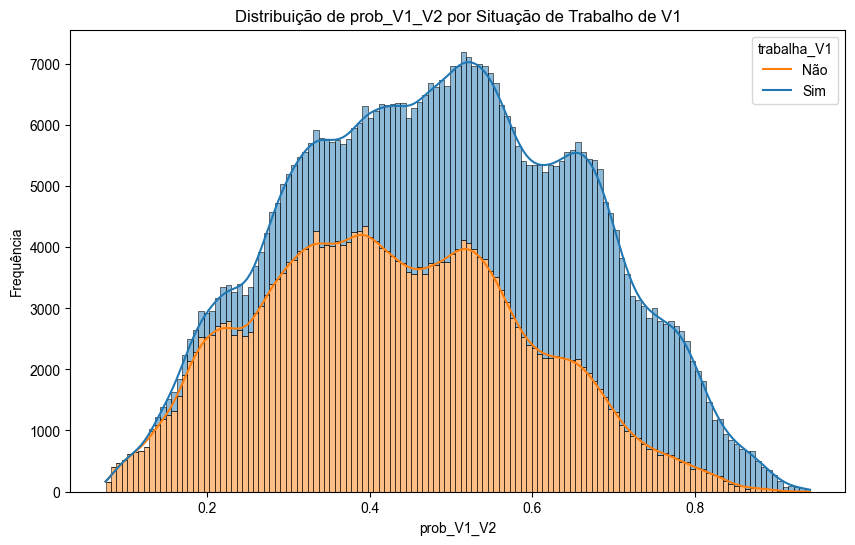

In [74]:
# Taxa de contágio por situação de trabalho de V1

plt.figure(figsize=(10, 6))
sns.histplot(data=df_model, x='prob_V1_V2', hue='trabalha_V1', kde=True, multiple='stack')
plt.title('Distribuição de prob_V1_V2 por Situação de Trabalho de V1')
plt.xlabel('prob_V1_V2')
plt.ylabel('Frequência')
plt.legend(title='trabalha_V1', labels=['Não', 'Sim'])
plt.show()

In [71]:
# Separando os dois grupos com base em trabalha_V1
trabalha = df_model.query('trabalha_V1 == 1.0')['prob_V1_V2'].dropna()
nao_trabalha = df_model.query('trabalha_V1 == 0.0')['prob_V1_V2'].dropna()

# Aplicando o teste de Wilcoxon Rank-Sum (RankSums)
r = ranksums(trabalha, nao_trabalha)

# Exibindo o p-valor
print(f'O valor do p-value é {r.pvalue:.4f}')

O valor do p-value é 0.0000


O trabalho tende a aumentar as taxas de contaminação.

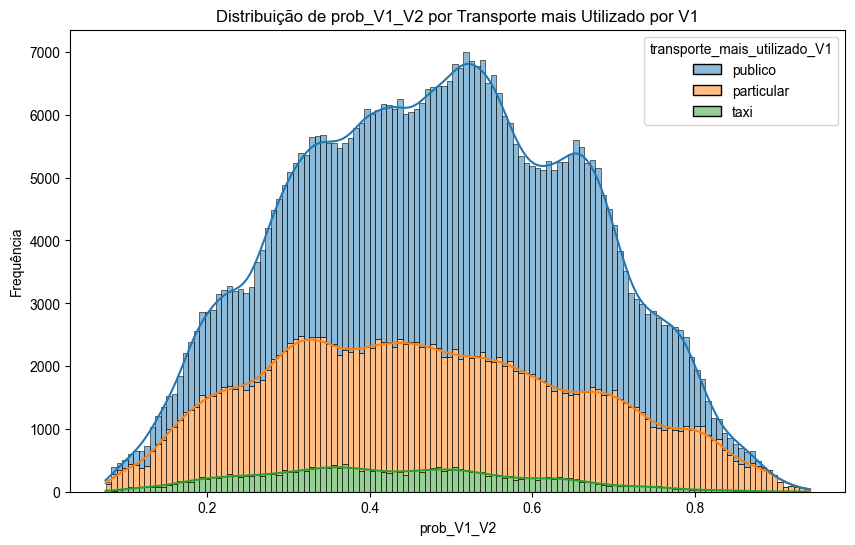

In [75]:
# Taxa de contágio por transporte mais utilizado por V1

plt.figure(figsize=(10, 6))
sns.histplot(data=df_model, x='prob_V1_V2', hue='transporte_mais_utilizado_V1', kde=True, multiple='stack')
plt.title('Distribuição de prob_V1_V2 por Transporte mais Utilizado por V1')
plt.xlabel('prob_V1_V2')
plt.ylabel('Frequência')
plt.show()

Transportes particulares/taxi tendem a ter taxas menores.

# 2. Modelagem

## 2.1 Pré-processando a tabela para a modelagem

Aqui experimentarei uma modelagem considerando as features de cada uns dos indivíduos cruzando com os dados de conexões (assim como na análise visual anterior).

In [9]:
# Renomeando colunas para o merge
df_ind_v1 = df_ind.rename(columns=lambda x: f"{x}_V1" if x != 'name' else 'V1')
df_ind_v2 = df_ind.rename(columns=lambda x: f"{x}_V2" if x != 'name' else 'V2')

# Merge dos dados com as conexões
df_merged = df_con.merge(df_ind_v1, on='V1', how='left')
df_merged = df_merged.merge(df_ind_v2, on='V2', how='left')

# Remover registros sem target (probabilidade de contagio)
df_model = df_merged[df_merged['prob_V1_V2'].notna()].copy()

display(df_model.head())

,V1,V2,grau,proximidade,prob_V1_V2,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,...,transporte_mais_utilizado_V1,IMC_V1,idade_V2,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2
0,1,2,trabalho,visita_frequente,0.589462,44.0,divorciado,1.0,1.0,0.0,...,publico,22.200956,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
1,1,3,trabalho,visita_rara,0.708465,44.0,divorciado,1.0,1.0,0.0,...,publico,22.200956,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,2,5,trabalho,visita_rara,0.638842,24.0,casado,0.0,0.0,0.0,...,publico,25.378720,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
5,3,7,familia,visita_casual,0.709608,35.0,solteiro,1.0,0.0,0.0,...,particular,19.952393,55.0,solteiro,1.0,1.0,1.0,1.0,particular,NaN
7,4,9,amigos,visita_casual,0.465209,50.0,casado,1.0,1.0,1.0,...,publico,26.732053,42.0,divorciado,1.0,0.0,1.0,NaN,publico,40.793339


## 2.2 Loop para teste de vários modelos

Primeiramente, um loop para um teste mais simples para compararmos o resultado de diversos modelos diferentes.

In [10]:
# Separar as features e o target, excluindo V1 e V2
X_raw = df_model.drop(columns=['V1', 'V2', 'prob_V1_V2'])
y = df_model['prob_V1_V2']

# One-hot encoding
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Imputar valores numéricos ausentes (depois de termos separados em treino e teste)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Lista de modelos testados
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Loop para treinar e avaliar cada modelo
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name}: RMSE = {rmse:.4f}")

Linear Regression: RMSE = 0.1157
Ridge: RMSE = 0.1157
Lasso: RMSE = 0.1738
Decision Tree: RMSE = 0.0794
Random Forest: RMSE = 0.0574
Gradient Boosting: RMSE = 0.0682
XGBoost: RMSE = 0.0551


## 2.3 Otimizando o modelo XGBRegressor

Um loop para buscar os hiperparâmetros otimizados para o modelo

In [11]:
# Carregando os dados para a modelagem

df_model = df_merged[df_merged['prob_V1_V2'].notna()].copy()

FEATURES = ['grau', 'proximidade', 'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 
            'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1', 
            'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 
            'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2']

X = df_model[FEATURES]
y = df_model['prob_V1_V2']

boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

categorical_cols = [
    'grau',
    'proximidade',
    'estado_civil_V1',
    'transporte_mais_utilizado_V1',
    'estado_civil_V2',
    'transporte_mais_utilizado_V2'
]

numerical_cols = list(set(FEATURES) - set(categorical_cols) - set(boolean_cols))

# Pré-processamento dos dados e separando as features por tipo

# Númericas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Booleanas
bool_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Categóricas
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combinando os pré-processadores em um ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('bool', bool_pipeline, boolean_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Pipeline de modelagem
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parâmetros para otimização do modelo
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Treinamento com busca em grade
grid_search.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid_search.best_params_}")

# Validacão cruzada

print(f"Melhor RMSE (validação cruzada): {-grid_search.best_score_:.4f}")

# Testando no conjunto de teste final
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE no teste final: {rmse_test:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores parâmetros: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}
Melhor RMSE (validação cruzada): 0.0504
RMSE no teste final: 0.0503


# 3. Salvando o modelo final

## 3.1 Treino com modelo otimizado

Treino do modelo com os parâmetros da otimização e export da pipeline.

In [ ]:
# Features

FEATURES = ['grau', 'proximidade', 'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 
            'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1', 
            'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 
            'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2']

X = df_model[FEATURES]
y = df_model['prob_V1_V2']

# Separando as features por tipo

boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

categorical_cols = [
    'grau',
    'proximidade',
    'estado_civil_V1',
    'transporte_mais_utilizado_V1',
    'estado_civil_V2',
    'transporte_mais_utilizado_V2'
]

numerical_cols = list(set(FEATURES) - set(categorical_cols) - set(boolean_cols))

# Pré-processamento
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

bool_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('bool', bool_pipeline, boolean_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Modelo com hiperparâmetros otimizados na etapa anterior
model = XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Separação em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treino
pipeline.fit(X_train, y_train)

# Avaliação
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE no teste final: {rmse:.4f}")  # Esperado: ~0.0547

# Salvando o modelo final .pkl
joblib.dump(pipeline, '../modelo/xgb_pipeline.pkl')

RMSE no teste final: 0.0503


['../modelo/xgb_pipeline.pkl']

In [13]:
# Listando as features para auxiliar na configuracão da API (app/api_modelo.py) que será testada no notebook 'notebooks/modelo_exe.ipynb'

print(X.columns.tolist())

['grau', 'proximidade', 'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1', 'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2']


## 3.2 Prevendo as taxas faltantes

Como foi solicitado, aqui preenchemos os dados faltantes de 'prob_V1_V2'.

In [ ]:
# Prever onde prob_V1_V2 é nulo
df_missing = df_merged[df_merged['prob_V1_V2'].isna()].copy()
X_missing = df_missing[FEATURES]

# Previsão
df_missing['prob_V1_V2'] = pipeline.predict(X_missing)

# Combinar os dados previstos com os dados originais
df_final = pd.concat([df_model, df_missing], axis=0)


colunas_para_dropar = [
    'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
    'transporte_mais_utilizado_V1', 'IMC_V1',
    'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2',
    'transporte_mais_utilizado_V2', 'IMC_V2'
]

# Drop das colunas no df_final
df_final = df_final.drop(columns=colunas_para_dropar, errors='ignore')



display(df_final.head())


,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
3,2,5,trabalho,visita_rara,0.638842
5,3,7,familia,visita_casual,0.709608
7,4,9,amigos,visita_casual,0.465209


In [76]:
# Verificando a base gerada

print(len(df_final))

print(df_final.dtypes)

print(df_final.isnull().sum())


999999
V1               int64
V2               int64
grau            object
proximidade     object
prob_V1_V2     float64
dtype: object
V1             0
V2             0
grau           0
proximidade    0
prob_V1_V2     0
dtype: int64


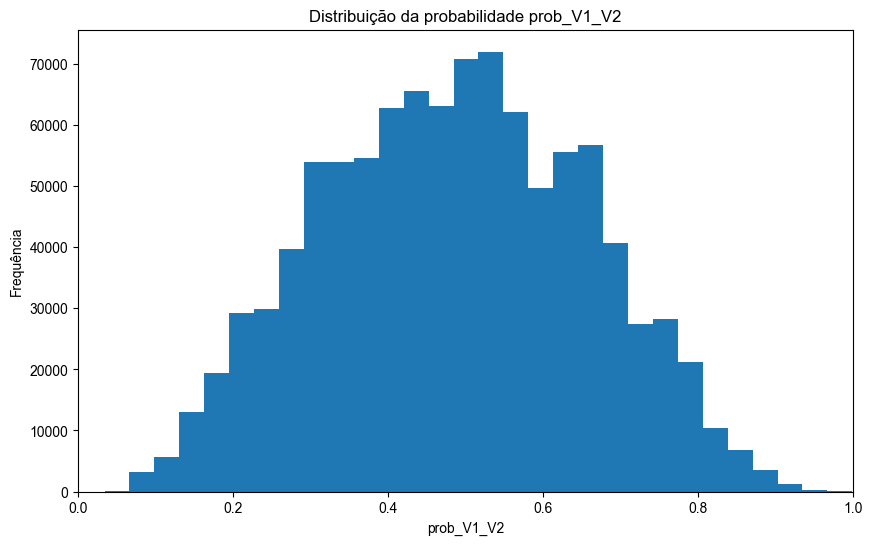

In [39]:
# Avaliando a distribuição final com as previsões

# Plotando o histograma das probabilidades
df_final['prob_V1_V2'].plot(
    kind='hist',
    figsize=(10, 6),
    bins=30,
    title='Distribuição da probabilidade prob_V1_V2'
)
plt.xlabel('prob_V1_V2')
plt.ylabel('Frequência')
plt.xlim(0, 1)
plt.show()

In [29]:
# Salvar o resultado
df_final.to_csv('../aux/conexoes_completo.csv', index=False)

#### Para vermos a importância das features concatenei as features novamente

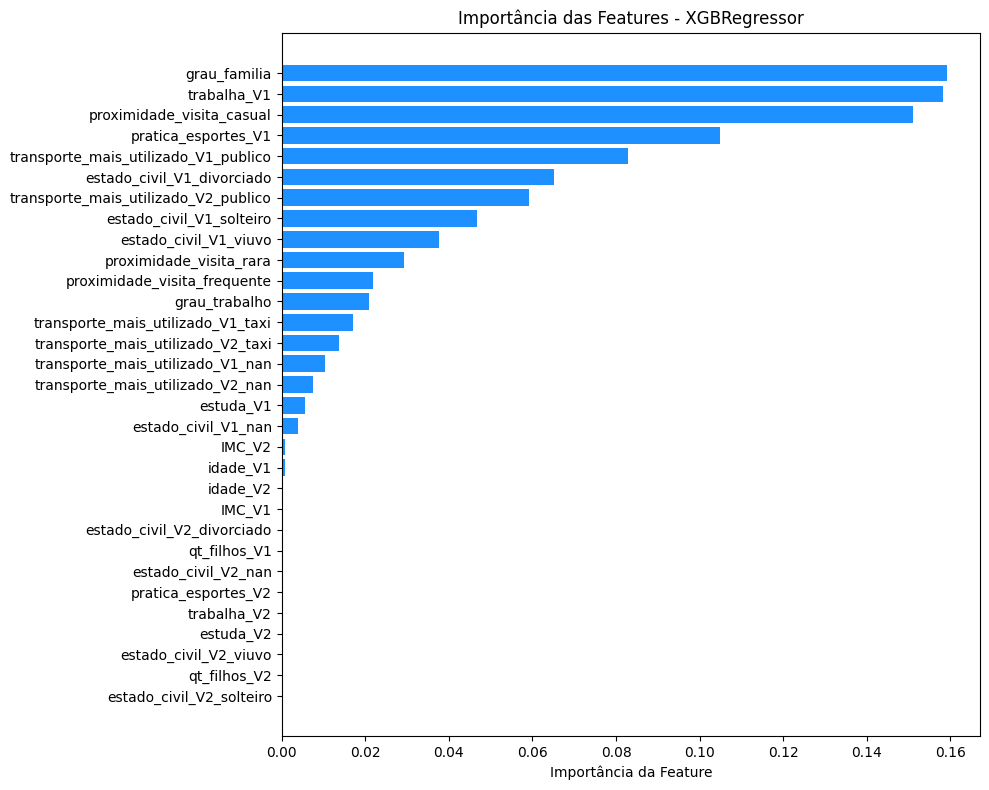

In [14]:
# Extrair o pré-processador do pipeline
preprocessor = best_model.named_steps['preprocessor']

# Obter as colunas numéricas e booleanas
num_cols = numerical_cols
bool_cols = boolean_cols

# Obter os nomes das colunas criadas pelo one-hot encoder para colunas categóricas
cat_transformer = preprocessor.named_transformers_['cat']
onehot = cat_transformer.named_steps['onehot']
cat_cols = onehot.get_feature_names_out(categorical_cols)

# Concatenar todos os nomes das features após o pré-processamento
feature_names = np.concatenate([num_cols, bool_cols, cat_cols])

# Extrair o modelo XGBRegressor treinado
model = best_model.named_steps['model']

# Obter a importância das features
importances = model.feature_importances_

# Criar dataframe para facilitar o plot
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=True)  # ordena para melhor visualização no gráfico

# Plotar o gráfico
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='dodgerblue')
plt.xlabel('Importância da Feature')
plt.title('Importância das Features - XGBRegressor')
plt.tight_layout()
plt.show()


Melhorando o design.

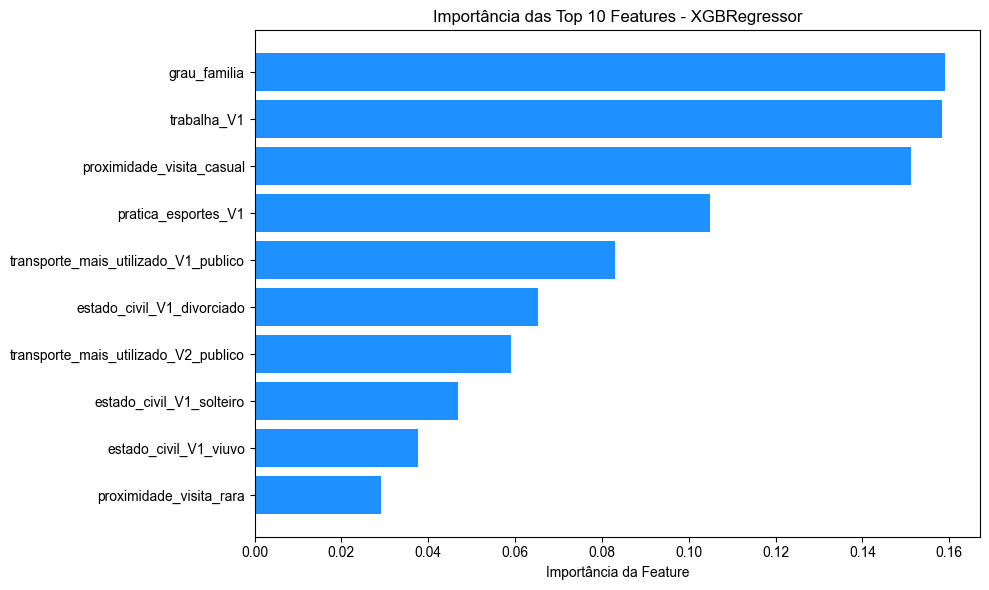

In [17]:
# Criar dataframe
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Selecionar as top 10 features por importância (decrescente)
top10 = feat_imp_df.sort_values(by='importance', ascending=False).head(10).sort_values(by='importance')

# Plotar gráfico horizontal das top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top10['feature'], top10['importance'], color='dodgerblue')

plt.xlabel('Importância da Feature', fontname='Arial')
plt.title('Importância das Top 10 Features - XGBRegressor', fontname='Arial')

# Ajustar fonte dos ticks do eixo y e x para Arial
plt.xticks(fontname='Arial')
plt.yticks(fontname='Arial')

plt.tight_layout()
plt.show()
